# <a id='toc1_'></a>[Using pretrained models to classify retinal damage from OCT Scans](#toc0_)

This notebook is inspired by these pages:

- [VGG11 Transfer Learning \- Pytorch \| Kaggle](https://www.kaggle.com/code/carloalbertobarbano/vgg11-transfer-learning-pytorch)
- [IgorSusmelj/pytorch\-styleguide: An unofficial styleguide and best practices summary for PyTorch](https://github.com/IgorSusmelj/pytorch-styleguide)

# **Table of contents**<a id='toc0_'></a>    

- [Using pretrained models to classify retinal damage from OCT Scans](#toc1_)    
  - [Table of Contents](#toc1_1_)    
- [Import and Settings](#toc2_)    
- [Prepare Data](#toc3_)    
  - [Setting data directory](#toc3_1_)    
  - [Setting transforms](#toc3_2_)    
  - [Setting datasets and dataloaders](#toc3_3_)    
- [Evaluation Tools](#toc4_)    
- [Model Creation](#toc5_)    
  - [Model Summaries](#toc5_1_)    
- [Evaluation before training](#toc6_)    
- [Training](#toc7_)    
  - [VGG11](#toc7_1_)    
  - [ResNet34](#toc7_2_)    
  - [EfficientNet](#toc7_3_)    
- [Evaluation after training](#toc8_)    
- [Summary](#toc9_)    

# <a id='toc2_'></a>[Import and Settings](#toc0_)

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from sklearn.utils import Bunch

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using CUDA


- `torch.backends.cudnn.benchmark = True` enables cudnn auto-tuner to find the best algorithm to use for your hardware configuration
- `np.random.seed(1)` sets the seed of the NumPy pseudo-random number generator to 1, which allows to repdoduce the same sequences of random numbers across runs.
- `torch.manual_seed(1)` sets the seed for generating random tensors in the CPU by PyTorch.
- `torch.cuda.manual_seed(1)` sets the seed for generating random tensors in the GPU by PyTorch.

In [2]:
# set flags / seeds
torch.backends.cudnn.benchmark = True
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# <a id='toc3_'></a>[Prepare Data](#toc0_)

In the below, I define `DataModule` that holds datasets and dataloaders.

## <a id='toc3_1_'></a>[Setting data directory](#toc0_)

``` python
    def __init__(self):
        # setting data directory
        self.data_dir = '../input/kermany2018/oct2017/OCT2017 '
        self.split_names = ["train", "val", "test"]
        ...
```


- `self.data_dir` holds a path to the data directory.
- `self.split_names` hold string values for three different subsets of data.

## <a id='toc3_2_'></a>[Setting transforms](#toc0_)

``` python
    def __init__(self):
        ...

        # setting data transforms
        self.data_transforms = self._get_transforms()

        ...

    def _get_transforms(self):
        # VGG-16 Takes 224x224 images as input, so we resize all of them
        data_transforms = {
            # train
            self.split_names[0]: transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ]),
            # val
            self.split_names[1]: transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ]),
            # test
            self.split_names[2]: transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])
        }
        
        # extend dictionaries by enabling values to be accessed by both key and attribute
        data_transforms = Bunch(**data_transforms)
        
        return data_transforms
```

For train:

- augmenting by randomly cropping and flipping the images to improve the model's ability to generalize to new data
- converting images to pytorch tensors

For val and test:

- resizing the images to 224x224 pixels to fit the VGG input size
- converting images to pytorch tensors

Finally I convert data_transforms to in the form of [sklearn\.utils\.Bunch](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html) to be easily accessible by attribute.

## <a id='toc3_3_'></a>[Setting datasets and dataloaders](#toc0_)

``` python
    def __init__(self):
        ...
        
        # setting datasets
        self.datasets = self._get_datasets()
        
        # setting dataloaders
        self.dataloaders = self._get_dataloaders()

        ...

    def _get_datasets(self):
        print("Preparing datasets ...")
        image_datasets = {
            x: datasets.ImageFolder(
                os.path.join(self.data_dir, x), 
                transform=self.data_transforms[x]
            )
            for x in self.split_names
        }
        print("Done!")
        
        # extend dictionaries by enabling values to be accessed by both key and attribute
        image_datasets = Bunch(**image_datasets)
        
        return image_datasets
    
    def _get_dataloaders(self):
        dataloaders = {
            x: torch.utils.data.DataLoader(
                self.datasets[x], batch_size=32,
                shuffle=True, num_workers=2
            )
            for x in self.split_names
        }
        
        # extend dictionaries by enabling values to be accessed by both key and attribute
        dataloaders = Bunch(**dataloaders)
        
        return dataloaders
```

- datasets
    - `datasets.ImageFolder()` expects a directory containing subdirectories of images (one subdirectory per class), and creates a dataset where each image is paired with its corresponding label.
    - `transform` argument is passed to specify image transformations to be applied defined above.
    - The three datasets (TRAIN, VAL and TEST) are stored in a dictionary.
- dataloaders
    - For each dataset, we creates a data loader by passing the corresponding `Dataset` object.
    - `shuffle` parameter is set to `True` to shuffle the elements in each batch.
    - `num_workers` is set to 2 to use 2 subprocesses to load in the background.
    - The three dataloaders (TRAIN, VAL and TEST) are stored in a dictionary.
- Finally we store the sizes of the three datasets in a dictionary `dataset_sizes`.

In [3]:
class DataModule():
    def __init__(self):
        # setting data directory
        self.data_dir = '../input/kermany2018/oct2017/OCT2017 '
        self.split_names = ["train", "val", "test"]
        
        # setting data transforms
        self.data_transforms = self._get_transforms()
        
        # setting datasets
        self.datasets = self._get_datasets()
        
        # setting dataloaders
        self.dataloaders = self._get_dataloaders()
        
        # setting dataset sizes
        dataset_sizes = {x: len(self.datasets[x]) for x in self.split_names}
        self.dataset_sizes = Bunch(**dataset_sizes)
        
        
    def _get_transforms(self):
        # VGG-16 Takes 224x224 images as input, so we resize all of them
        data_transforms = {
            # train
            self.split_names[0]: transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
            ]),
            # val
            self.split_names[1]: transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ]),
            # test
            self.split_names[2]: transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])
        }
        
        # extend dictionaries by enabling values to be accessed by both key and attribute
        data_transforms = Bunch(**data_transforms)
        
        return data_transforms
    
    def _get_datasets(self):
        print("Preparing datasets ...")
        image_datasets = {
            x: datasets.ImageFolder(
                os.path.join(self.data_dir, x), 
                transform=self.data_transforms[x]
            )
            for x in self.split_names
        }
        print("Done!")
        
        # extend dictionaries by enabling values to be accessed by both key and attribute
        image_datasets = Bunch(**image_datasets)
        
        return image_datasets
    
    def _get_dataloaders(self):
        dataloaders = {
            x: torch.utils.data.DataLoader(
                self.datasets[x], batch_size=32,
                shuffle=True, num_workers=2
            )
            for x in self.split_names
        }
        
        # extend dictionaries by enabling values to be accessed by both key and attribute
        dataloaders = Bunch(**dataloaders)
        
        return dataloaders

Let's check it out!

In [4]:
datamodule = DataModule()

# checking data sizes
for split, size in datamodule.dataset_sizes.items():
    print(f"Loaded {size} images under {split}")

# checking what classes are in the dataset
print()
print("Classes: ")
print(datamodule.datasets.train.classes)

Preparing datasets ...
Done!
Loaded 83484 images under train
Loaded 32 images under val
Loaded 968 images under test

Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']


# <a id='toc4_'></a>[Evaluation Tools](#toc0_)

In here I define a class `EvaluationTools` that has 4 main methods:

- `show_databatch`
- `visualize_model`
- `eval_model`
- `model_summary`

In [5]:
class EvaluationTools():
    def __init__(
        self,
        model = None,
        dataloader = None,
        class_names = None,
        criterion = None,
    ):
        self.model = model
        self.dataloader = dataloader
        self.class_names = class_names
        self.criterion = criterion
    
    def imshow(self, inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        plt.axis('off')
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)
        
    def show_databatch(self, num_images=None):
        inputs, classes = next(iter(self.dataloader))
        
        if num_images is not None:
            inputs = inputs[:num_images]
            classes = classes[:num_images]
        
        self._show_databatch(inputs, classes, self.class_names)
        
    def visualize_model(self, num_images=6):
        self._visualize_model(self.model, self.dataloader, num_images=num_images)
        
    def eval_model(self):
        self._eval_model(
            self.model,
            self.dataloader,
            self.criterion,
        )
        
    def model_summary(self):
        return self._model_summary(self.model)
        
    def _show_databatch(self, inputs, classes, class_names):
        out = torchvision.utils.make_grid(inputs)
        self.imshow(out, title=[class_names[x] for x in classes])

    def _visualize_model(self, model, dataloader, num_images=8):
        was_training = model.training

        # Set model for evaluation
        model.eval()

        with torch.no_grad():
            inputs, classes = next(iter(dataloader))
            
            device = self._check_device()
            inputs = inputs.to(device)
            classes = classes.to(device)
            model.to(device)
                
            if num_images is not None:
                inputs = inputs[:num_images]
                classes = classes[:num_images]

            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)

            print("Ground truth:")
            self._show_databatch(inputs.detach().cpu(), classes.detach().cpu(), self.class_names)
            print("Prediction:")
            self._show_databatch(inputs.detach().cpu(), preds, self.class_names)

            del inputs, classes, outputs, preds
            torch.cuda.empty_cache()

        model.train(mode=was_training)  # Revert model back to original training state
        
    def _eval_model(self, model, data_loader, criterion):
        since = time.time()
        avg_loss = 0
        avg_acc = 0
        loss_test = 0
        acc_test = 0
        total_size = 0

        test_batches = len(data_loader)
        print("Evaluating model")
        print("-" * 10)

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(data_loader):

                if i % 5 == 0:
                    message = (
                        f"\rTest batch {i}/{test_batches}"
                        + ",  "
                        + f"Avg loss (test): {avg_loss:.4f}"
                        + ",  "
                        + f"Avg acc (test): {avg_acc:.4f}"
                    )
                    print(message, end="", flush=True)

                

                inputs, classes = data
                inputs_size = inputs.size(0)

                device = self._check_device()
                inputs = inputs.to(device)
                classes = classes.to(device)
                model.to(device)

                outputs = model(inputs)

                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, classes)

                loss_test += loss.item()
                acc_test += torch.sum(preds == classes).item()

                total_size += inputs_size

                avg_loss = loss_test / total_size
                avg_acc = acc_test / total_size

                del inputs, classes, outputs, preds
                torch.cuda.empty_cache()

        avg_loss = loss_test / total_size
        avg_acc = acc_test / total_size

        elapsed_time = time.time() - since
        print()
        print("=" * 10)
        print(
            "Evaluation completed in {:.0f}m {:.0f}s".format(
                elapsed_time // 60, elapsed_time % 60
            )
        )
        print("Avg loss (test): {:.4f}".format(avg_loss))
        print("Avg acc (test): {:.4f}".format(avg_acc))
        print("-" * 10)
        
        self.avg_loss = avg_loss
        self.avg_acc = avg_acc
        
    def _model_summary(self, model):
        batch_size = 2

        return summary(
            model,
            input_size=(batch_size, 3, 224, 224),
            col_names = [
                "output_size",
                "params_percent",
                "trainable",
            ]
        )
    
    def _check_device(self):
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
        return device

Let's look at some images!

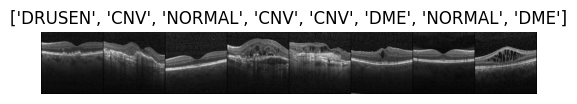

In [6]:
evaltools = EvaluationTools(
    dataloader = datamodule.dataloaders.test,
    class_names = datamodule.datasets.test.classes,
)
evaltools.show_databatch(8)

# <a id='toc5_'></a>[Model Creation](#toc0_)

Here I define 3 model classes. "TL" is short for "Transfer Learning".:

- `VGG11TL`
    - VGG is known for its simplicity and has achieved impressive results in image classification tasks.
- `ResNet34TL`
    - ResNet is built on the idea of residual connections, which allow the network to learn residual functions instead of trying to learn the original mapping directly.
- `EfficientNetTL`
    - EfficientNet uses a combination of efficient building blocks, including mobile inverted bottleneck and squeeze-and-excitation modules, to achieve high accuracy with fewer parameters and faster inference times.

In [7]:
class VGG11TL(nn.Module):
    def __init__(self, n_classes=4, fine_tune=False) -> None:
        super().__init__()

        self.n_classes = n_classes
        self.fine_tune = fine_tune
        self.vgg = self._setup_vgg()

    def forward(self, x):
        x = self.vgg(x)
        return x

    def _setup_vgg(self):
        # load pretrained model
        vgg = models.vgg11_bn(
            weights="DEFAULT",
        )

        if not self.fine_tune:
            # freeze weights of feature extractor
            for param in vgg.features.parameters():
                param.requires_grad = False

        # replace last layer
        in_features = vgg.classifier[-1].in_features
        vgg.classifier[-1] = nn.Linear(in_features, self.n_classes)

        return vgg

In [8]:
class ResNet34TL(nn.Module):
    def __init__(self, n_classes=4, fine_tune=False) -> None:
        super().__init__()

        self.n_classes = n_classes
        self.fine_tune = fine_tune
        self.resnet = self._setup_resnet()

    def forward(self, x):
        x = self.resnet(x)
        return x

    def _setup_resnet(self):
        # load pretrained model
        resnet = models.resnet34(
            weights="DEFAULT",
        )

        if not self.fine_tune:
            # freeze weights of feature extractor
            for param in resnet.parameters():
                param.requires_grad = False

        # replace last layer
        in_features = resnet.fc.in_features
        resnet.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.n_classes)
        )

        return resnet

In [9]:
class EfficientNetTL(nn.Module):
    def __init__(self, n_classes=4, fine_tune=False) -> None:
        super().__init__()

        self.n_classes = n_classes
        self.fine_tune = fine_tune
        self.efficientnet = self._setup_efficientnet()

    def forward(self, x):
        x = self.efficientnet(x)
        return x

    def _setup_efficientnet(self):
        # load pretrained model
        efficientnet = models.efficientnet_v2_s(
            weights="DEFAULT",
        )
        
        if not self.fine_tune:
            # freeze weights of feature extractor
            for param in efficientnet.parameters():
                param.requires_grad = False

        # replace last layer
        in_features = efficientnet.classifier[-1].in_features
        efficientnet.classifier[-1] = nn.Linear(in_features, self.n_classes)

        return efficientnet

## <a id='toc5_1_'></a>[Model Summaries](#toc0_)

In [10]:
FINE_TUNE = True

In [11]:
vgg11 = VGG11TL(fine_tune=FINE_TUNE)

evaltools_vgg = EvaluationTools(
    model=vgg11,
    dataloader = datamodule.dataloaders.test,
    class_names = datamodule.datasets.test.classes,
)
evaltools_vgg.model_summary()

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:03<00:00, 141MB/s]
/opt/conda/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/conda/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param %                   Trainable
VGG11TL                                  [2, 4]                         --                   True
├─VGG: 1-1                               [2, 4]                         --                   True
│    └─Sequential: 2-1                   [2, 512, 7, 7]                 --                   True
│    │    └─Conv2d: 3-1                  [2, 64, 224, 224]           0.00%                   True
│    │    └─BatchNorm2d: 3-2             [2, 64, 224, 224]           0.00%                   True
│    │    └─ReLU: 3-3                    [2, 64, 224, 224]              --                   --
│    │    └─MaxPool2d: 3-4               [2, 64, 112, 112]              --                   --
│    │    └─Conv2d: 3-5                  [2, 128, 112, 112]          0.06%                   True
│    │    └─BatchNorm2d: 3-6             [2, 128, 112, 112]          0.00%                   True
│    │    └─ReLU: 3

In [12]:
resnet34 = ResNet34TL(fine_tune=FINE_TUNE)

evaltools_resnet = EvaluationTools(
    model=resnet34,
    dataloader = datamodule.dataloaders.test,
    class_names = datamodule.datasets.test.classes,
)
evaltools_resnet.model_summary()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 64.4MB/s]


Layer (type:depth-idx)                        Output Shape              Param %                   Trainable
ResNet34TL                                    [2, 4]                         --                   True
├─ResNet: 1-1                                 [2, 4]                         --                   True
│    └─Conv2d: 2-1                            [2, 64, 112, 112]           0.04%                   True
│    └─BatchNorm2d: 2-2                       [2, 64, 112, 112]           0.00%                   True
│    └─ReLU: 2-3                              [2, 64, 112, 112]              --                   --
│    └─MaxPool2d: 2-4                         [2, 64, 56, 56]                --                   --
│    └─Sequential: 2-5                        [2, 64, 56, 56]                --                   True
│    │    └─BasicBlock: 3-1                   [2, 64, 56, 56]             0.35%                   True
│    │    └─BasicBlock: 3-2                   [2, 64, 56, 56]           

In [13]:
efficientnet = EfficientNetTL(fine_tune=FINE_TUNE)

evaltools_efficientnet = EvaluationTools(
    model=efficientnet,
    dataloader = datamodule.dataloaders.test,
    class_names = datamodule.datasets.test.classes,
)
evaltools_efficientnet.model_summary()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 51.0MB/s]


Layer (type:depth-idx)                                       Output Shape              Param %                   Trainable
EfficientNetTL                                               [2, 4]                         --                   True
├─EfficientNet: 1-1                                          [2, 4]                         --                   True
│    └─Sequential: 2-1                                       [2, 1280, 7, 7]                --                   True
│    │    └─Conv2dNormActivation: 3-1                        [2, 24, 112, 112]           0.00%                   True
│    │    └─Sequential: 3-2                                  [2, 24, 112, 112]           0.05%                   True
│    │    └─Sequential: 3-3                                  [2, 48, 56, 56]             1.50%                   True
│    │    └─Sequential: 3-4                                  [2, 64, 28, 28]             2.92%                   True
│    │    └─Sequential: 3-5                        

# <a id='toc6_'></a>[Evaluation before training](#toc0_)

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
evaltools_vgg.criterion = criterion
evaltools_vgg.eval_model()

Evaluating model
----------
Test batch 30/31,  Avg loss (test): 0.0430,  Avg acc (test): 0.3021
Evaluation completed in 0m 11s
Avg loss (test): 0.0440
Avg acc (test): 0.3017
----------


In [16]:
evaltools_resnet.criterion = criterion
evaltools_resnet.eval_model()

Evaluating model
----------
Test batch 30/31,  Avg loss (test): 0.0445,  Avg acc (test): 0.2510
Evaluation completed in 0m 6s
Avg loss (test): 0.0455
Avg acc (test): 0.2521
----------


In [17]:
evaltools_efficientnet.criterion = criterion
evaltools_efficientnet.eval_model()

Evaluating model
----------
Test batch 30/31,  Avg loss (test): 0.0423,  Avg acc (test): 0.3542
Evaluation completed in 0m 7s
Avg loss (test): 0.0434
Avg acc (test): 0.3512
----------


# <a id='toc7_'></a>[Training](#toc0_)

In [18]:
class Trainer:
    def __init__(
        self,
        model,
        train_data_loader,
        val_data_loader,
        criterion,
        optimizer,
        num_epochs: int = 10,
        resume: bool = False,
        path_to_checkpoint=None,
        checkpoint_dir=None,
    ):
        self.model = model
        self.train_data_loader = train_data_loader
        self.val_data_loader = val_data_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.resume = resume
        self.path_to_checkpoint = path_to_checkpoint
        self.n_iter = 0
        self.start_epoch = 0
        self.epoch = 0
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.checkpoint_dir = checkpoint_dir
        self.train_losses = []
        self.train_acc = []
        self.train_time = None

        if self.resume:
            ckpt = self.load_checkpoint(self.path_to_checkpoint)
            self.model.load_state_dict(ckpt["net"])
            self.start_epoch = ckpt["epoch"]
            self.n_iter = ckpt["n_iter"]
            self.optimizer.load_state_dict(ckpt["optim"])
            print("Last checkpoint restored")

        self.model.to(self.device)

    def train_step(self):
        self.model.train()
        
        correct = 0
        total = 0

        # use prefetch_generator and tqdm for iterating through data
        pbar = tqdm(
            enumerate(self.train_data_loader), total=len(self.train_data_loader)
        )
        start_time = time.time()

        # for loop going through dataset
        for i, data in pbar:

            # data preparation
            img, label = data
            img = img.to(self.device)
            label = label.to(self.device)

            # It's very good practice to keep track of preparation time and computation time using tqdm to find any issues in your dataloader
            prepare_time = start_time - time.time()

            # forward and backward pass
            out = self.model(img)
            loss = self.criterion(out, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            _, predicted = torch.max(out.detach(), 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            accuracy = 100 * correct / total
            
            # compute computation time and *compute_efficiency*
            # If compute_efficiency is nearly 1, prepare_time is negligible, that's good.
            process_time = start_time - time.time() - prepare_time
            compute_efficiency = process_time / (process_time + prepare_time)
            pbar.set_description(
                f"Compute efficiency: {compute_efficiency:.2f}, "
                f"loss: {loss.item():.2f},  acc: {accuracy:.2f},  epoch: {self.epoch}/{self.num_epochs}"
            )
            start_time = time.time()
            
            self.train_losses.append(loss.item())
            self.train_acc.append(accuracy)
            self.n_iter += 1

    def validation_step(self):
        # bring model to evaluation mode
        self.model.eval()

        correct = 0
        total = 0

        pbar = tqdm(
            enumerate(self.val_data_loader),
            total=len(self.val_data_loader),
        )

        with torch.no_grad():
            for i, data in pbar:

                # data preparation
                img, label = data
                img = img.to(self.device)
                label = label.to(self.device)

                out = self.model(img)
                _, predicted = torch.max(out.detach(), 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        print(f"Accuracy on validation set: {accuracy:.2f}")

    def load_checkpoint(self, path_to_checkpoint):
        ckpt = torch.load(path_to_checkpoint)
        return ckpt

    def save_checkpoint(self):
        ckpt = {
            "net": self.model.state_dict(),
            "epoch": self.epoch,
            "n_iter": self.n_iter,
            "optim": self.optimizer.state_dict(),
        }

        ckpt_file_name = f"ckpt.pt"
        ckpt_path = os.path.join(self.checkpoint_dir, ckpt_file_name)

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

        torch.save(ckpt, ckpt_path)
        print(f"checkpoint is saved at {ckpt_path}!")
    
    def plot_train_progress(self):
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        ax1.plot(self.train_losses, label="train_loss", color="tab:blue")
        ax2.plot(self.train_acc, label="train_acc", color="tab:orange")
        
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc='lower right')
        fig.show()

    def train(self):
        start_time = time.time()
        
        for epoch in range(self.start_epoch, self.num_epochs):
            # train step
            self.train_step()

            # validation step
            if epoch % 1 == 0:
                self.validation_step()

            self.epoch += 1
            
        # save checkpoint
        self.save_checkpoint()
        
        train_time = time.time() - start_time
        self.train_time = train_time


## <a id='toc7_1_'></a>[VGG11](#toc0_)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)

trainer_vgg = Trainer(
    model=vgg11,
    train_data_loader=datamodule.dataloaders.train,
    val_data_loader=datamodule.dataloaders.val,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    resume=False,
    checkpoint_dir="/kaggle/working/ckpt/vgg/",
)

Compute efficiency: 1.00, loss: 0.67,  acc: 87.08,  epoch: 0/1: 100%|██████████| 2609/2609 [12:41<00:00,  3.43it/s]
100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Accuracy on validation set: 100.00
checkpoint is saved at /kaggle/working/ckpt/vgg/ckpt.pt!
Train time:	 764.3906350135803 [sec]


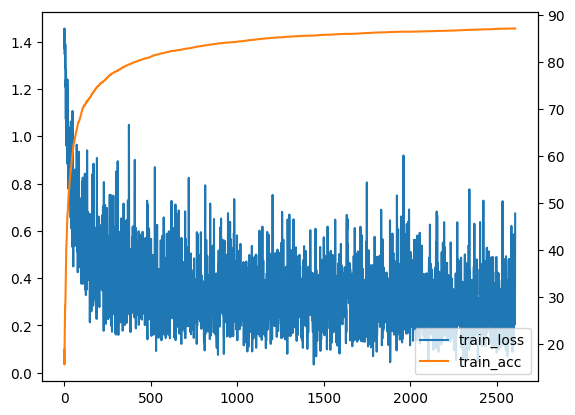

In [20]:
trainer_vgg.train()

trainer_vgg.plot_train_progress()
print("Train time:\t", trainer_vgg.train_time, "[sec]")

In [21]:
evaltools_vgg.model = trainer_vgg.model.cpu()
torch.cuda.empty_cache()

## <a id='toc7_2_'></a>[ResNet34](#toc0_)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9)

trainer_resnet = Trainer(
    model=resnet34,
    train_data_loader=datamodule.dataloaders.train,
    val_data_loader=datamodule.dataloaders.val,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    resume=False,
    checkpoint_dir="/kaggle/working/ckpt/resnet/",
)

Compute efficiency: 0.99, loss: 0.27,  acc: 86.92,  epoch: 0/1: 100%|██████████| 2609/2609 [10:25<00:00,  4.17it/s]
100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Accuracy on validation set: 100.00
checkpoint is saved at /kaggle/working/ckpt/resnet/ckpt.pt!
Train time:	 626.4695551395416 [sec]


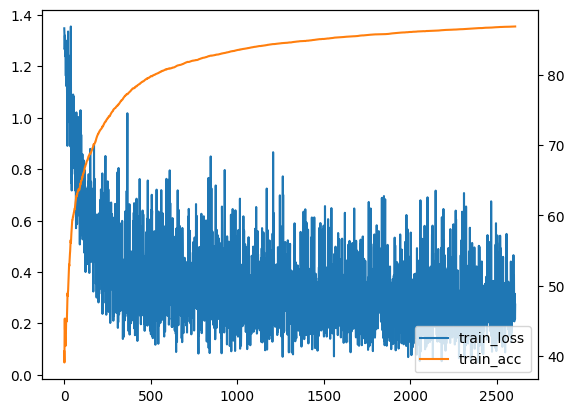

In [23]:
trainer_resnet.train()

trainer_resnet.plot_train_progress()
print("Train time:\t", trainer_resnet.train_time, "[sec]")

In [24]:
resnet34 = trainer_resnet.model.cpu()
torch.cuda.empty_cache()

## <a id='toc7_3_'></a>[EfficientNet](#toc0_)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet.parameters(), lr=0.001, momentum=0.9)

trainer_efficientnet = Trainer(
    model=efficientnet,
    train_data_loader=datamodule.dataloaders.train,
    val_data_loader=datamodule.dataloaders.val,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    resume=False,
    checkpoint_dir="/kaggle/working/ckpt/efficientnet/",
)

Compute efficiency: 0.99, loss: 0.06,  acc: 86.41,  epoch: 0/1: 100%|██████████| 2609/2609 [16:10<00:00,  2.69it/s]
100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Accuracy on validation set: 100.00
checkpoint is saved at /kaggle/working/ckpt/efficientnet/ckpt.pt!
Train time:	 971.5122058391571 [sec]


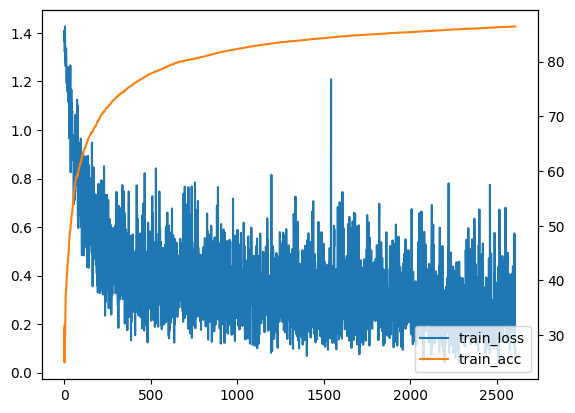

In [26]:
trainer_efficientnet.train()

trainer_efficientnet.plot_train_progress()
print("Train time:\t", trainer_efficientnet.train_time, "[sec]")

In [27]:
efficientnet = trainer_efficientnet.model.cpu()
torch.cuda.empty_cache()

# <a id='toc8_'></a>[Evaluation after training](#toc0_)

In [28]:
evaltools_vgg.eval_model()

Evaluating model
----------
Test batch 30/31,  Avg loss (test): 0.0009,  Avg acc (test): 0.9938
Evaluation completed in 0m 7s
Avg loss (test): 0.0009
Avg acc (test): 0.9938
----------


In [29]:
evaltools_resnet.eval_model()

Evaluating model
----------
Test batch 30/31,  Avg loss (test): 0.0020,  Avg acc (test): 0.9812
Evaluation completed in 0m 6s
Avg loss (test): 0.0021
Avg acc (test): 0.9814
----------


In [30]:
evaltools_efficientnet.eval_model()

Evaluating model
----------
Test batch 30/31,  Avg loss (test): 0.0008,  Avg acc (test): 0.9938
Evaluation completed in 0m 7s
Avg loss (test): 0.0008
Avg acc (test): 0.9938
----------


# <a id='toc9_'></a>[Summary](#toc0_)

In [31]:
df_summary = pd.DataFrame({
    "model": ["VGG11", "ResNet34", "EfficientNet_V2"],
    "n_params": ["128M", "21M", "20M"],
    "train_time": [trainer_vgg.train_time, trainer_resnet.train_time, trainer_efficientnet.train_time],
    "test_acc": [evaltools_vgg.avg_acc, evaltools_resnet.avg_acc, evaltools_efficientnet.avg_acc],
}).set_index("model")

df_summary

,n_params,train_time,test_acc
model,,,
VGG11,128M,764.390635,0.993802
ResNet34,21M,626.469555,0.981405
EfficientNet_V2,20M,971.512206,0.993802
